In [ ]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()

In [ ]:
import zipfile
import io

# Replace 'your_uploaded_file.zip' with the actual file name
with zipfile.ZipFile(io.BytesIO(uploaded['archive.zip']), 'r') as zip_ref:
    zip_ref.extractall('your_extracted_folder')

In [8]:
import numpy as np
from PIL import Image
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import seaborn as sns
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [9]:
dirctory = r'PLD_3_Classes_256/Training'
catagories = ['Early_Blight','Healthy','Late_Blight']
data_train = []
for category in catagories:
    folder = os.path.join(dirctory,category)
    label = catagories.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder,img)
        image_arr = np.array(Image.open(img_path))
        #print(image_arr.size)
        #plt.imshow(image_arr)
        #break
        data_train.append([image_arr,label])
print(len(data_train))

3251


In [10]:
dirctory = r'PLD_3_Classes_256/Testing'
catagories = ['Early_Blight','Healthy','Late_Blight']
data_test = []
for category in catagories:
    folder = os.path.join(dirctory,category)
    label = catagories.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder,img)
        image_arr = np.array(Image.open(img_path))
        #print(image_arr.size)
        #plt.imshow(image_arr)
        #break
        data_test.append([image_arr,label])
print(len(data_test))

405


In [11]:
dirctory = r'PLD_3_Classes_256/Validation'
catagories = ['Early_Blight','Healthy','Late_Blight']
data_valid = []
for category in catagories:
    folder = os.path.join(dirctory,category)
    label = catagories.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder,img)
        image_arr = np.array(Image.open(img_path))
        #print(image_arr.size)
        #plt.imshow(image_arr)
        #break
        data_valid.append([image_arr,label])
print(len(data_valid))

416


In [12]:
random.shuffle(data_train)
random.shuffle(data_test)
random.shuffle(data_valid)

In [13]:
x_train = []
y_train = []
for feature,labels in data_train:
    x_train.append(feature)
    y_train.append(labels)
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape,y_train.shape)

(3251, 256, 256, 3) (3251,)


In [14]:
x_test = []
y_test = []
for feature,labels in data_test:
    x_test.append(feature)
    y_test.append(labels)
x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_test.shape,y_test.shape)

(405, 256, 256, 3) (405,)


In [15]:
x_valid = []
y_valid = []
for feature,labels in data_valid:
    x_valid.append(feature)
    y_valid.append(labels)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
print(x_valid.shape,y_valid.shape)

(416, 256, 256, 3) (416,)


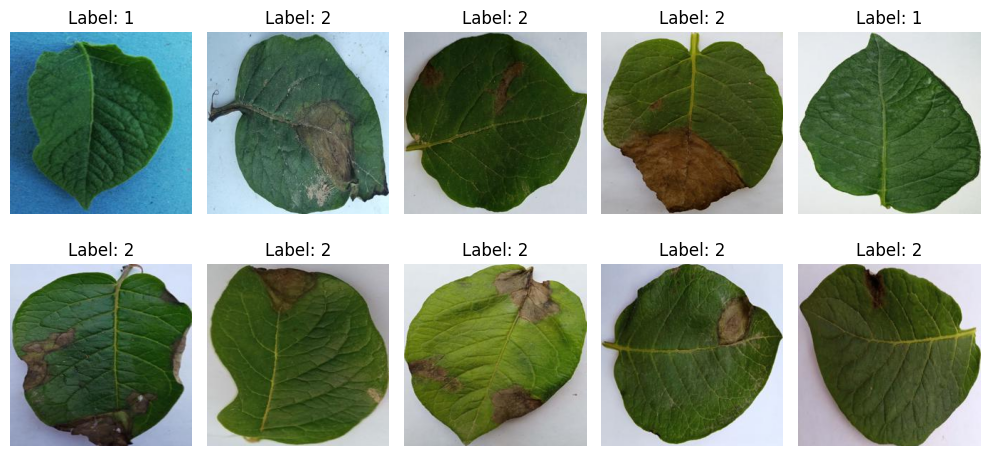

In [16]:
# Visualize sample images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(x_train[i].reshape(256, 256,3), cmap='gray')
    axes[i].set_title(f"Label: {y_train[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [17]:
from sklearn.preprocessing import OneHotEncoder

# Reshape the labels to a 2D array
y_train = y_train.reshape(-1, 1)

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the labels
y_train_encoded = encoder.fit_transform(y_train)

In [18]:
# Reshape the labels to a 2D array
y_test = y_test.reshape(-1, 1)

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the labels
y_test_encoded = encoder.fit_transform(y_test)

In [19]:
# Reshape the labels to a 2D array
y_valid = y_valid.reshape(-1, 1)

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the labels
y_valid_encoded = encoder.fit_transform(y_valid)

In [20]:
def vgg16_model(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(layers.Conv2D(2, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    return model

In [21]:
def inception_module(x, filters):
    conv1x1_1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = layers.Conv2D(filters[1], (3, 3), padding='same', activation='relu')(x)
    conv5x5 = layers.Conv2D(filters[2], (5, 5), padding='same', activation='relu')(x)
    
    maxpool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_2 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(maxpool)
    
    inception_block = layers.concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_2], axis=-1)
    
    return inception_block

In [22]:
input_shape = (256, 256, 3)  # CIFAR-10 images are 32x32 pixels with three channels
num_classes = 3

input_layer = layers.Input(shape=input_shape)
vgg16_output = vgg16_model(input_shape)(input_layer)

inception_output = inception_module(vgg16_output, [64, 64, 32, 32])

# Flatten and add fully connected layers for classification
x = layers.Flatten()(inception_output)
x = layers.Dense(512, activation='relu')(x)
output_layer = layers.Dense(num_classes, activation='softmax')(x)

# Create the combined model
combined_model = models.Model(inputs=input_layer, outputs=output_layer)

In [23]:
# Compile the model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Display the model architecture
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  


 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 32)           123586    ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)           0         ['sequential[0][0]']          
 g2D)                                                                                             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 32, 32, 64)           2112      ['sequential[0][0]']          
                                                                                                  
 conv2d_8 (Conv2D)           (None, 32, 32, 64)           18496     ['sequential[0][0]']          
          

In [25]:
batch_size = 64
epochs = 1  # You can adjust the number of epochs as needed

# Train the model
combined_model.fit(x_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid_encoded))

51/51 [==============================] - 908s 18s/step - loss: 27.2339 - accuracy: 0.3913 - val_loss: 1.0799 - val_accuracy: 0.3918


In [27]:
# Evaluate the model on the test set
loss, accuracy = combined_model.evaluate(x_test, y_test_encoded, verbose=2)

# Print the test accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")

13/13 - 21s - loss: 1.0826 - accuracy: 0.4000 - 21s/epoch - 2s/step
Test Accuracy: 40.00%


In [28]:
# Evaluate the model on the test set
loss, accuracy = combined_model.evaluate(x_train, y_train_encoded, verbose=2)

# Print the test accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")

102/102 - 187s - loss: 1.0822 - accuracy: 0.4008 - 187s/epoch - 2s/step
Test Accuracy: 40.08%


In [29]:
y_pred = combined_model.predict(x_train)
import numpy as np

# Convert one-hot encoded label to integer label
int_label = np.argmax(y_pred,axis=1)

# Print the integer label
print("Integer label:", int_label)

102/102 [==============================] - 193s 2s/step
Integer label: [0 0 0 ... 0 0 0]


In [30]:
print(int_label.shape,y_pred.shape)

(3251,) (3251, 3)


c:\Users\Sameh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sameh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sameh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.40      1.00      0.57      1303
           1       0.00      0.00      0.00       816
           2       0.00      0.00      0.00      1132

    accuracy                           0.40      3251
   macro avg       0.13      0.33      0.19      3251
weighted avg       0.16      0.40      0.23      3251



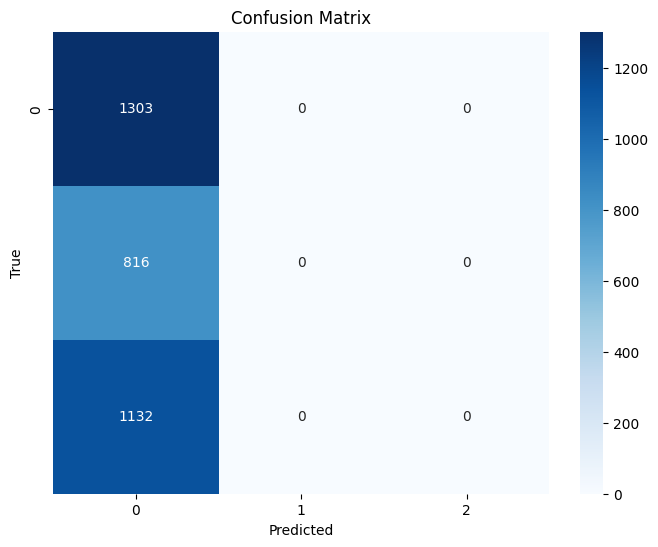

In [32]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_train, int_label)

# Print the classification report
print(report)

from sklearn.metrics import confusion_matrix



# Create confusion matrix
cm = confusion_matrix(y_train, int_label)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(int_label))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()